# Sensitivity Analysis - Random Forest + SHAP

### ADDS V5

Product of V3. 3,000 less rows after adding 'wind_height' variable into the new working dataset.
We execute SHAP method to a Rnadom Forest Regressor made with the working data frame.

### Data Pre-Processing

We start by preparing our Dataframe. First, we will load the data and libraries required.

**NOTE:** We are required to use NumPy 2.2 or below (specified on requirements.txt), for using shap library, due to compatibility issues.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import shap # For SHAP method execution
from sklearn.ensemble import RandomForestRegressor # For construction of surrogate model
from sklearn.model_selection import train_test_split # For training and testing of the model
from sklearn.preprocessing import LabelEncoder # For encoding categorical features

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


An explotatory analysis was made before for constructing the working dataframe. For required reference, consult the latest version of EDA noteboook.

We continue by loading our dataframe.

In [2]:
df = pd.read_csv("./data/working_df_v3.csv")

We define the discrete columns to be encoded before the analysis, and, just as an extra, visualize the domains for the continuous columns, including outputs.

In [5]:
discrete_columns = [ 'side_to_start_ignition', 'firing_technique', 'ignition_type' ]

In [6]:
min_max_df = df.agg(['min', 'max'])
min_max_df = min_max_df.drop(columns=discrete_columns)
min_max_df

,Unnamed: 0,fuel_id,unit_feature_id,surface_consumed,midstory_consumed,canopy_consumed,fdfm,lfm,wind_speed,wind_direction,wind_height,number_igniters,dash_length,gap_length,blackline_width,spacing_distance,igniter_velocity,ignition_time
min,0,569,14,0.003862,0.000000,0.000000,0.02,0.20,0.0,0.0,5.0,1,6.096000e-01,9.143554e-01,0.0,1.219141,2.235136e-01,90.434320
max,8038,3047,3648,0.996155,0.861364,0.487125,0.80,2.46,90.0,352.0,60.0,20,6.325338e+26,1.243535e+28,100.0,65.000000,6.682500e+18,45297.804314


Now, we proceed by encoding the discrete columns, so we may do a continuous analysis with the construction of a surrogate model via Random Forest Regressor. We don't use classifiers, as the 3 outputs of the BurnPro3D model are continuous.

In [7]:
# Variables Encoding
label_encoders = {}

for col in discrete_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

We define the input and output columns before training the surrogate models.

In [8]:
# Inputs Based on Dataframe
inputs_list = ['fdfm','lfm','wind_speed', 'wind_direction', 'wind_height', 'dash_length', 'gap_length',
          'blackline_width', 'spacing_distance', 'igniter_velocity', 'ignition_time', 
          'side_to_start_ignition', 'firing_technique', 'ignition_type' ] 

inputs = df[inputs_list]

# Outputs Based on Dataframe
# y_surface = df['surface_consumed']
# y_midstory = df['midstory_consumed']
# y_canopy = df['canopy_consumed']

outputs_list = ['surface_consumed', 'midstory_consumed', 'canopy_consumed']

outputs = df[outputs_list]

We can now form a loop for training and executing each sensitivity analysis per output. We append them for future reference if required too.

In [9]:
# For appending data
models = {}
explainers = {}
shap_values_dict = {}
x_test_dict = {}  # Store x_test for each output

for output in outputs_list:

    # Drop columns with y = NaN
    # df_filtered = df.dropna(subset=[output] + inputs_list)
    df_filtered = df.dropna(subset=[output])

    # Adjust inputs and outputs for excluding dropped columns
    x = df_filtered[inputs_list]
    y = df_filtered[output]

    # Random Forest Regressor execution
    # x = df_filtered[inputs_list].reset_index(drop=True)
    # y = df_filtered[output].reset_index(drop=True)

    # assert x.isnull().sum().sum() == 0  # check for NaNs
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor()
    model = model.fit(x_train, y_train)
    models[output] = model
    x_test_dict[output] = x_test  # Store x_test for this output

    # SHAP Method execution
    # Tree Explainer
    explainer = shap.TreeExplainer(model, x_train)
    explainers[output] = explainer

    # Shap Values Recollection
    shap_values = explainer.shap_values(x_test, check_additivity=False)
    shap_values_dict[output] = shap_values

100%|===================| 1255/1259 [00:51<00:00]        

We may now visualize each SHAP analysis per output, for future interpretation.


== SHAP Analysis for Output: surface_consumed ==
Model: RandomForestRegressor()
                   feature  importance
10           ignition_time    0.078250
12        firing_technique    0.063145
0                     fdfm    0.062274
2               wind_speed    0.050340
6               gap_length    0.024072
9         igniter_velocity    0.023710
8         spacing_distance    0.012585
4              wind_height    0.012134
3           wind_direction    0.010721
7          blackline_width    0.006301
11  side_to_start_ignition    0.004249
1                      lfm    0.003930
5              dash_length    0.002992
13           ignition_type    0.000000


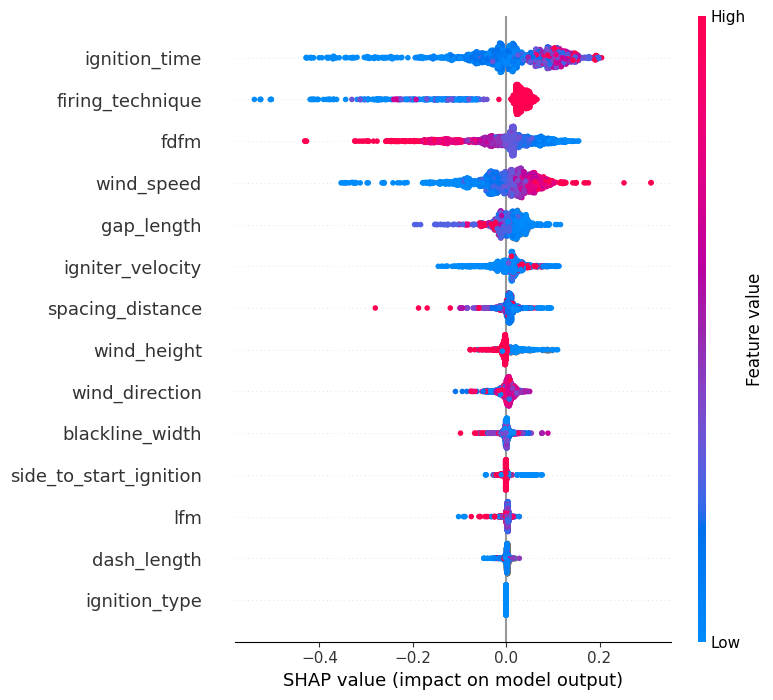


== SHAP Analysis for Output: midstory_consumed ==
Model: RandomForestRegressor()
                   feature  importance
10           ignition_time    0.079018
12        firing_technique    0.044458
0                     fdfm    0.032452
6               gap_length    0.030948
3           wind_direction    0.029630
2               wind_speed    0.026029
9         igniter_velocity    0.022837
8         spacing_distance    0.022397
5              dash_length    0.020469
7          blackline_width    0.013515
4              wind_height    0.009605
1                      lfm    0.007106
11  side_to_start_ignition    0.003007
13           ignition_type    0.000000


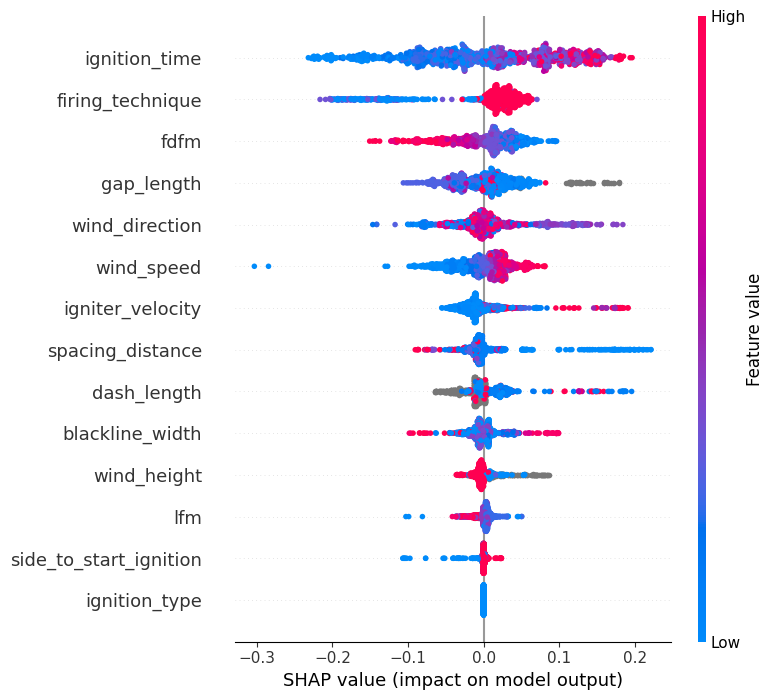


== SHAP Analysis for Output: canopy_consumed ==
Model: RandomForestRegressor()
                   feature  importance
10           ignition_time    0.031570
3           wind_direction    0.022593
6               gap_length    0.010973
9         igniter_velocity    0.008467
2               wind_speed    0.008322
8         spacing_distance    0.006299
0                     fdfm    0.005615
7          blackline_width    0.005334
5              dash_length    0.003751
4              wind_height    0.003464
12        firing_technique    0.002013
1                      lfm    0.000720
11  side_to_start_ignition    0.000554
13           ignition_type    0.000000


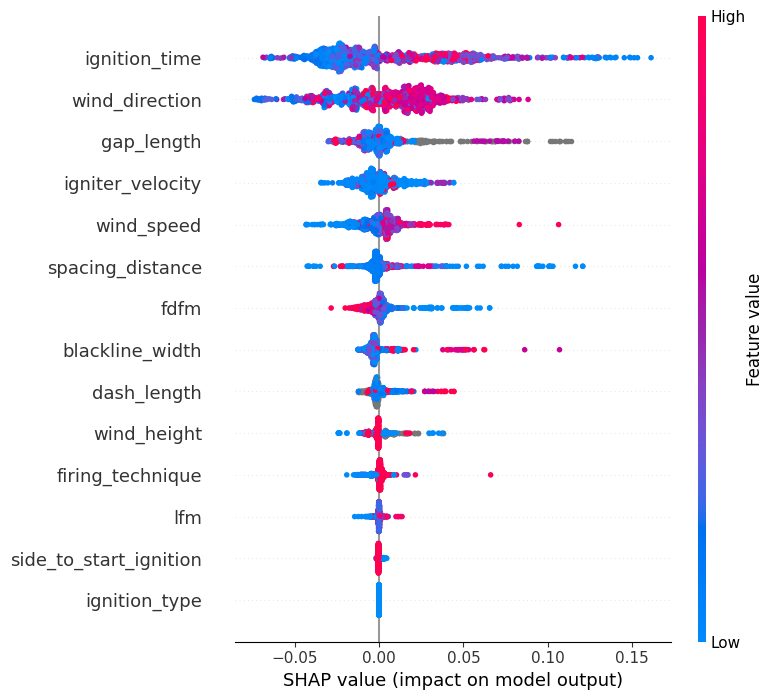

In [10]:
# Results Display
for output in outputs_list:
    print(f"\n== SHAP Analysis for Output: {output} ==")
    print("Model:", models[output])
    shap_values = shap_values_dict[output]

    x_test = x_test_dict[output]
    
    # Top SHAP values Ranked
    shap_abs_mean = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame({
        "feature": x_test.columns,
        "importance": shap_abs_mean
    }).sort_values("importance", ascending=False)
    
    print(feature_importance)  # features

    # SHAP summary plot
    shap.summary_plot(shap_values, x_test)